Импортируем необходимые библиотеки для работы с данными

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from io import StringIO
import re
import requests
from urllib.parse import urlencode
import time
%matplotlib inline

Выгрузим наши дата сеты и проведем базовую проверку на количество строк, количество пропусков и на типы данных!

In [2]:
# Реализуем функцию для выгрузки файлов с гугл диска
def df_downloader(link, separator=','):
    # Извлекаем ID файла из ссылки
    file_id = link.split('/d/')[1].split('/')[0]
    
    # Формируем ссылку на скачивание
    download_url = f'https://drive.google.com/uc?id={file_id}'
    
    # Отправляем запрос на данные
    response = requests.get(download_url)
    
    # Проверяем статус ответа
    if response.status_code == 200:
        # Читаем скачанный файл с выбранным разделителем
        df_temp = pd.read_csv(StringIO(response.text), sep=separator)
        return df_temp
    else:
        print(f"Ошибка при скачивании файла: {response.status_code} - {response.text}")
        return None


groups_url = 'https://drive.google.com/file/d/1-KrIB3jYebsGJbN93MwgXtOD9rrTt1XN/view?usp=sharing'
active_studs_url = 'https://drive.google.com/file/d/1-LmgoSVmzV0bfIumUQuZJIxoC4PQb9zL/view?usp=sharing'
checks_url = 'https://drive.google.com/file/d/1-c8BfF2AXbjt_WzhEmRaskeX8CWqRBhK/view?usp=sharing'

groups = df_downloader(groups_url)
active_studs = df_downloader(active_studs_url)
checks = df_downloader(checks_url)


Предобработаем для удобства датафрейм **groups**, сделав отдельную колонку с id студента 
и отдельную с принадлежностью к контрольной либо тестовой группе. Понимаю, что можно при выгрузке файла другой сепаратор указать, но я намеренно оставил ',' , чтобы потом провести некую обработку данных в колонках!

In [3]:
groups['student_id'] = groups['id;grp'].apply(lambda x: x.split(';')[0])
groups['group'] = groups['id;grp'].apply(lambda x: x.split(';')[1])
groups = groups[['student_id', 'group']]

In [4]:
groups.isna().sum()

student_id    0
group         0
dtype: int64

In [5]:
groups.dtypes

student_id    object
group         object
dtype: object

In [6]:
groups.group.value_counts()

group
B    59813
A    14671
Name: count, dtype: int64

C датафреймом **groups** всё в порядке (пропусков нет, колонки преведены к нужным типам данных). Обратим внимание на перекос выборок для контрольной и экспрериментальной групп! Экспериментальная группа группа примерно в **4** раза больше контрольной!

In [7]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [8]:
active_studs.dtypes

student_id    int64
dtype: object

In [9]:
# Изменим тип данных колонки student_id с int на odject
active_studs['student_id'] = active_studs['student_id'].astype(str)

In [10]:
active_studs.student_id.nunique()

8341

C датафреймом **active_studs** всё в порядке. У нас **8341** активный студент (зашедшие на платформу в дни проведения эксперимента)!

Предобработаем для удобства датафрейм **checks**, сделав отдельную колонку с id студента  
и отдельную с оплатой студента.

In [11]:
checks['student_id'] = checks['student_id;"rev"'].apply(lambda x: x.split(';')[0])
checks['revenue'] = checks['student_id;"rev"'].apply(lambda x: x.split(';')[1])
checks = checks[['student_id', 'revenue']]

In [12]:
checks.isna().sum()

student_id    0
revenue       0
dtype: int64

In [13]:
checks.dtypes

student_id    object
revenue       object
dtype: object

In [14]:
# Тип колонки с оплатой изменим с object на float
checks['revenue'] = checks['revenue'].astype(float)

In [15]:
checks.student_id.nunique()

541

In [16]:
# Обратим внимание на то, что в наших данных у кажлого платящего студента есть только 1 оплата
checks.groupby('student_id', as_index=False).agg({'revenue' : 'count'}).revenue.unique()

array([1], dtype=int64)

C датафреймом **checks** всё в порядке. У нас **541** платящий студент в дни проведения эксперимента и у каждого платящего студента всего 1 оплата! 

### Соберём датафрейм **active_users_and_checks** с платящими и не платящими студентами, поучавствовавшими в эксперименте, с разбивкой по группам, по которому будем обсчитывать интересующие нас  метрики!

In [17]:
active_users_and_checks = active_studs.merge(checks, on='student_id', how = 'left').merge(groups, on='student_id')
active_users_and_checks['revenue'] = active_users_and_checks['revenue'].round(2)
active_users_and_checks['revenue'] = active_users_and_checks['revenue'].fillna(0) # Пропуски в оплатах заполним 0-ми

In [18]:
# Количество платящих студентов, поучавствовавших в эксперименте
active_users_and_checks.query('revenue != 0').student_id.nunique()

391

In [19]:
# Количество студентов, поучавствовавших в эксперименте
active_users_and_checks.student_id.nunique()

8328

In [20]:
# Количество платящих студентов в эсперименте в разбивке по группам
active_users_and_checks.query('revenue != 0').groupby('group', as_index=False).agg({'student_id': 'nunique'})

,group,student_id
0,A,78
1,B,313


In [21]:
# Количество студентов, поучавствовавших в эсперименте в разбивке по группам
active_users_and_checks.groupby('group', as_index=False).agg({'student_id': 'nunique'})

,group,student_id
0,A,1535
1,B,6793


In [22]:
# Сформируем отдельно контрольную и тестовую группы
group_A = active_users_and_checks.query('group == "A" and revenue != 0')
group_B = active_users_and_checks.query('group == "B" and revenue != 0')

Получим интересующие нас выборки **ARPPU** в контрольной и тестовой группе

In [23]:
ARPPU_control = group_A.revenue
ARPPU_test = group_B.revenue

In [24]:
ARPPU_A = ARPPU_control.mean().round(2)
ARPPU_B = ARPPU_test.mean().round(2)

In [25]:
# Посмотрим на различия в ARPPU в контрольной и тестовой группах
print(f'ARPPU в контрольной группе = {ARPPU_A}')
print(f'ARPPU в тестовой группе = {ARPPU_B}')
print(f'ARPPU в тестовой группе увеличился на {((ARPPU_test.mean().round(2) - ARPPU_control.mean().round(2)) * 100 / ARPPU_control.mean().round(2)).round(2)}%')

ARPPU в контрольной группе = 933.59
ARPPU в тестовой группе = 1255.83
ARPPU в тестовой группе увеличился на 34.52%


По предварительным расчётам мы видим , что в тестовой группе увеличилась **ARPPU** на **34.52%**!

### Теперь необходимо узнать статистически значимы ли эти различия!

**Так как мы имеем дело с денежной метрикой, то понимаем что ARPPU и распределены ненормально (скорее всего будет достаточно много небольших трат или чеков и мало больших чеков) и использовать проверку на нормальность при помощи теста Шапиро-Уилка, к примеру, будет излишним! Для проверки статистической значимости в изменениях ARPPU будем использовать бутстрап**

**Проверим статистическую значимость изменений в метрике ARPPU!**

Сформулируем нулевую и альтернативную гипотезы:

H0 - cтатистически значимых различий **ARPPU** в контрольной и тестовой группах нет.

H1 - ARPPU в тестовой группе статистически значимо увеличилось по сравнению с **ARPPU** в контрольной группе.

In [26]:
# Реализуем функцию для формирования подвыборок и проверки на стат значимость в ARPPU
def bootstrap(control, test, alpha=0.05): 
    
    start_time = time.time()
    # Определение ARPPU в контрольной и тестовой группах
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    print(f"Cреднее в контрольной группе: {mean_control}")
    print(f"Cреднее в тестовой группе: {mean_test}")
    
    # Генерация бутстрап-подвыборок
    n_bootstrap_samples = 10000
    bootstrap_means_diff = []
    
    for _ in range(n_bootstrap_samples):
        # Генерируем выборки , размером равным максимальному из наших групп
        bootstrap_sample_control = control.sample(len(control), replace=True)
        bootstrap_sample_test = test.sample(len(test), replace=True)
        
        # Расчёт средних в каждой подвыборке
        bootstrap_mean_control = np.mean(bootstrap_sample_control)
        bootstrap_mean_test = np.mean(bootstrap_sample_test)
        
        # Сборка списка из изменений средних в подвыборках
        bootstrap_mean_diff = bootstrap_mean_test - bootstrap_mean_control
        bootstrap_means_diff.append(bootstrap_mean_diff)
    

    # Расчет доверительного интервала изменений средних
    lower_bound = np.percentile(bootstrap_means_diff, 100 * (alpha / 2))
    upper_bound = np.percentile(bootstrap_means_diff, 100 * (1 - alpha / 2))
    confidence_interval = (lower_bound, upper_bound)
    
    # Визуализация распределения бутстрап-выборок
    plt.figure(figsize=(8, 6))
    sns.histplot(data=bootstrap_means_diff, legend=False)
    plt.title('Разница между средними в группах')
    plt.axvline(x = lower_bound, color='r', linestyle='--')
    plt.axvline(x = upper_bound, color='r', linestyle='--')
    plt.tight_layout()
    plt.grid()
    
    classic_time = time.time() - start_time
    print(f"Время выполнения классического бутстрапа: {classic_time:.4f} секунд")
    
    return {'confidence_interval': confidence_interval}

Cреднее в контрольной группе: 933.5897435897435
Cреднее в тестовой группе: 1255.8274760383385
Время выполнения классического бутстрапа: 1.2643 секунд


{'confidence_interval': (92.659670680757, 536.9460842139756)}

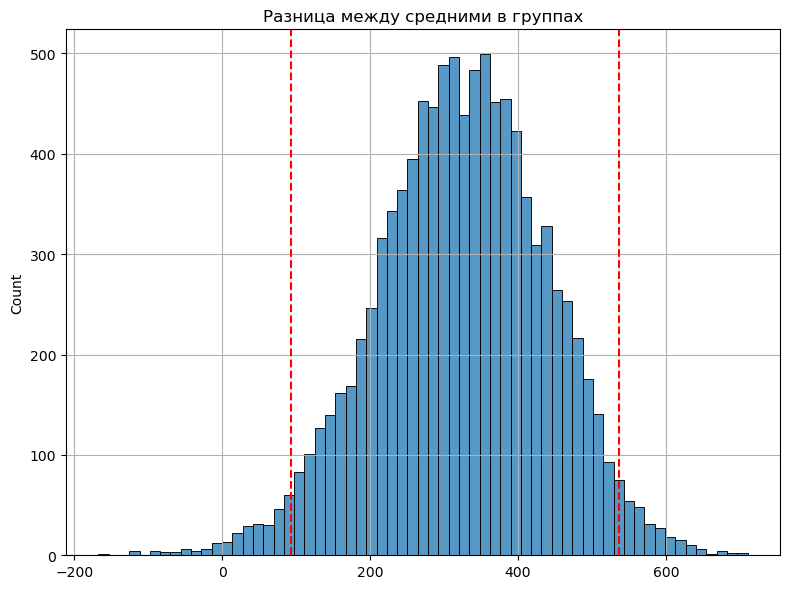

In [27]:
bootstrap(ARPPU_control, ARPPU_test, alpha=0.05)

Мы видим что доверительный интервал изменений средних **ARPPU** из подвыборок (count = 10000) не пересекает 0, тогда мы можем говорить о том , что у нас достаточно оснований , для того чтобы отклонить 0-ю гипотезу и изменения в **ARPPU**  в контрольной и тестовой группах статистически значимы! 

**Так как классический бутстрап очень ресурсозатратен в плане вычислительной мощности , а подвыборок мы хотим извлекать очень много для достоверности результатов, то его применение при больших выборках в контрольной и тестовой группах (сотни тысяч в каждой группе) вызывает большие сомнения! Конкретно в нашем случае выборки в контроле и тесте не очень большие и всё работает быстро, но мы предположим , что они были бы огромными и попытаемся реализовать Пуассоновский бутстрап , в котором подвыборки будут формироваться не просто случайным сэмплированием с повторением, а из Пуассоновского распределения c lambda = 1, т е для каждого наблюдения в бутстрап выборке мы получим вес этого наблюдения из Пуассоновского распределения и умножим его на значение ARPPU и так повторим 10000 раз. Таким обоазом, помятуя о том что Пуассоновский бутстрап не зависит от конечного количества наблюдений, а может выполняться потоково и может быть остановлен в любой момент, мы хотим ускорить наш тест в разы!**

Проверим как работает Пуассновский бутстрап для наших выборок, хотя у нас и небольшое количество наблюдений!

In [28]:
def generate_poisson_samples(data, lambda_param, B):
    """Генерация пуассоновских выборок."""
    # Генерируем B выборок из пуассоновского распределения
    return np.random.poisson(lam=lambda_param, size=(len(data), B))

def poisson_bootstrap(control, test, B, alpha=0.05):
    start_time = time.time()
    
    lambda_poisson = 1  # Параметр λ для пуассоновского распределения
    
    # Генерация бутстрап-выборок для контрольной и тестовой групп
    df_result_control = generate_poisson_samples(control, lambda_poisson, B)
    df_result_test = generate_poisson_samples(test, lambda_poisson, B)
    # Подсчёт средних нельзя выполнять командой mean, т к у нас не всегда количество появлений строки совпадает с длиной колонки
    means_control = (df_result_control.T * control).sum(axis = 1) / df_result_control.T.sum(axis = 1)
    means_test = (df_result_test.T * test).sum(axis = 1) / df_result_test.T.sum(axis = 1)
    
    # Рассчитываем разницу средних
    differenc = means_test - means_control
    
    # Рассчитываем доверительный интервал
    lower_bound = np.percentile(differenc, 100 * (alpha / 2))
    upper_bound = np.percentile(differenc, 100 * (1 - alpha / 2))
    confidence_interval = (lower_bound, upper_bound)
    
    # Визуализация распределения бутстрап-выборок
    plt.figure(figsize=(8, 6))
    sns.histplot(differenc, bins=30, legend=False)
    plt.title('Разница между средними в группах')
    plt.axvline(x=lower_bound, color='r', linestyle='--')
    plt.axvline(x=upper_bound, color='r', linestyle='--')
    plt.tight_layout()
    plt.grid()
    
    classic_time = time.time() - start_time
    print(f"Время выполнения пуассоновского бутстрапа: {classic_time:.4f} секунд")
    
    return {'confidence_interval': confidence_interval}



Время выполнения пуассоновского бутстрапа: 0.1535 секунд


{'confidence_interval': (95.2734403467681, 539.8581924262903)}

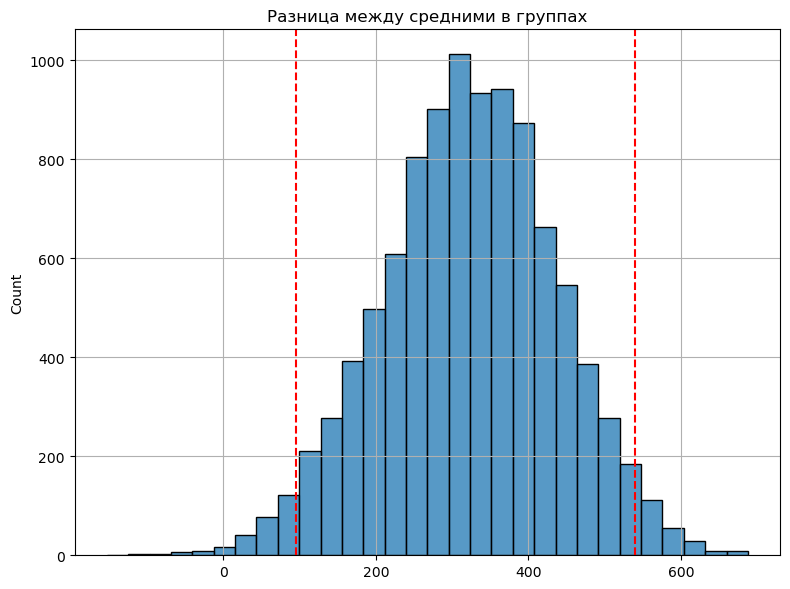

In [29]:
poisson_bootstrap(list(ARPPU_control), list(ARPPU_test), B=10000, alpha=0.05)

Мы видим что доверительный интервал изменений средних **ARPPU** из подвыборок (count = 10000) не пересекает 0 и наш Пуассоновский бутстрап также показал стат значимые различия в группах и код выполнился в 6 раз быстрее! Ну а вообще Пуассоновский бутстрап предназначен для больших выборок (сотни тысяч строк),  при которых вероятность появления каждого элемента в каждой итерации бутстрапа сходится к Пуассоновскому распределению и не зависит от количества наблюдений в выборке, в то время как в классическом бутстрапе такая вероятность появления элемента в каждой итерации носит биномиальный характер распределения! 

In [30]:
# Смоделируем ситуацию , в которой нам нужно сэмплировать выборку в 100000 элементов разными способами
# и посмотрим на время выполнения данных сэмплов
sample_size = 100000 # объем выборки
lambda_param_control = 1 / ARPPU_control.mean()  # параметр λ
data = np.random.exponential(scale=1/lambda_param_control, size=sample_size).tolist()
B = 10000

# Пуассоновский сэмпл
start_time = time.time()
weights_1 = np.random.poisson(1, (sample_size, B))
weights_1.T * data
classic_time = time.time() - start_time
print(f"Время выполнения пуассоновского метода: {classic_time:.4f} секунд")

# Классический сэмпл с повторением
start_time_2 = time.time()
list_1 = []
for i in range(B):
    weights_2 = pd.Series(data).sample(sample_size, replace = True)
    list_1.append(weights_2)
classic_time_2 = time.time() - start_time_2   
print(f"Время выполнения классического метода: {classic_time_2:.4f} секунд")

Время выполнения пуассоновского метода: 28.0557 секунд
Время выполнения классического метода: 50.7148 секунд


Видим, что даже на выборке в 100000 наблюдений Пуассоновский бутстрап оказался в 2 раза быстрее!

### Выводы:

 **В результате исследования классического и Пуассоновского бустрапа можно сделать вывод о том, что на больших объемах данных (порядка миллиона наблюдений) классический бутстрап очень сложно применять из за ресурсозатратности, в то время как Пуассоновский бутстрап на таких выборках будет работать гораздо быстрее**